In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import joblib

In [34]:
data_set = pd.read_csv('../data/processed/classified_maize_data.csv')
target_col = 'health_status'
cat_col = 'inferred_stage'
numeric_cols = [c for c in data_set.columns if c not in [target_col, cat_col]]
for c in numeric_cols:
    if data_set[c].dtype == object:
        data_set[c] = data_set[c].astype(str).str.replace(',', '', regex=False).str.replace('%', '', regex=False).str.strip()
    data_set[c] = pd.to_numeric(data_set[c], errors='coerce')
nan_counts = data_set[numeric_cols].isna().sum()
print('NaNs after conversion (per column):')
print(nan_counts[nan_counts > 0])
for c in numeric_cols:
    if data_set[c].isna().any():
        data_set[c].fillna(data_set[c].median(), inplace=True)
if cat_col in data_set.columns:
    data_set[cat_col] = data_set[cat_col].astype(str).fillna('unknown').str.strip()
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe_arr = ohe.fit_transform(data_set[[cat_col]])
    ohe_cols = [f'{cat_col}__' + str(v) for v in ohe.categories_[0]]
    ohe_df = pd.DataFrame(ohe_arr, columns=ohe_cols, index=data_set.index)
    # drop original categorical column and append the one-hot columns
    data_set = pd.concat([data_set.drop(columns=[cat_col]), ohe_df], axis=1)



NaNs after conversion (per column):
Series([], dtype: int64)


In [35]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
x =data_set.drop('health_status', axis=1)
y = data_set['health_status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)



0.9925925925925926

In [36]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        61
           1       0.99      1.00      1.00       209

    accuracy                           0.99       270
   macro avg       1.00      0.98      0.99       270
weighted avg       0.99      0.99      0.99       270



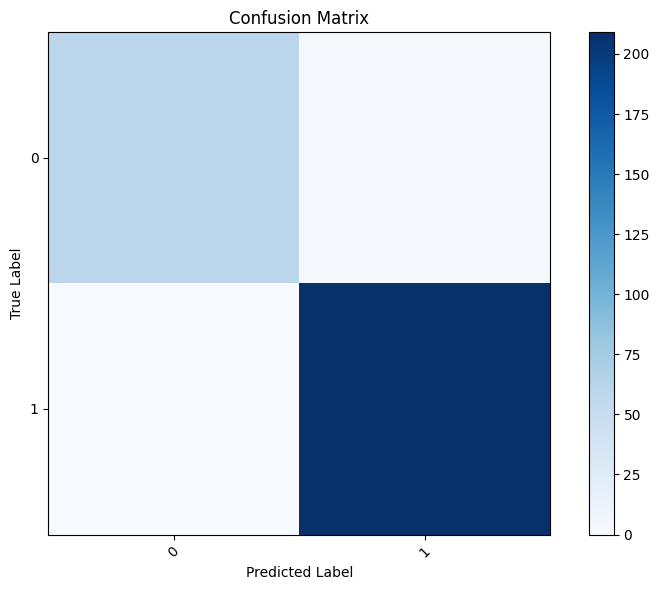

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(model.classes_))
plt.xticks(tick_marks, model.classes_, rotation=45)
plt.yticks(tick_marks, model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

In [38]:
joblib.dump(model, '../model/maize_health_model.joblib')



['../model/maize_health_model.joblib']